2020-09-12, Bogumił Kamiński

A companion notebook to the blog post:
https://bkamins.github.io/julialang/2020/07/11/cont.html

Loading required packages

In [1]:
using DataFrames
using ForwardDiff
using GLM
using Optim
using PyPlot
using Random
using StatsBase

Definition of the function that will be used to run simulations

In [2]:
function cont_run(time=10000, n=10000, λ=0.05, q=0.1)
    r = zeros(time)
    θ = zeros(n)
    pchange = zeros(n)
    for t = 1:time
        ε = randn()
        if ε > 0
            r[t] =  sum(<(ε), θ) / (λ * n)
        else
            r[t] =  -sum(<(-ε), θ) / (λ * n)
        end
        θ .= ifelse.(rand!(pchange) .< q, abs(r[t]), θ)
    end
    return kurtosis(r)
end

cont_run (generic function with 5 methods)

We run simulation twice and measure run time; on the first run the compilation time is included in the timings.

In [3]:
@time cont_run()

  0.090996 seconds (6 allocations: 234.609 KiB)


0.3496706139505772

In [4]:
@time cont_run()

  0.134615 seconds (6 allocations: 234.609 KiB)


0.322679944526731

Define a function that runs a whole simulation sweep. We store the results in a `DataFrame`.

In [5]:
function run_sim(time=10000, n=10000, reps=51)
    df = DataFrame()
    for λ in range(0.01, 0.05, length=51), q in range(0.01, 0.05, length=51)
        push!(df, (λ=λ, q=q, k=cont_run(time, n, λ, q)))
    end
    return df
end

run_sim (generic function with 4 methods)

Run the simulation. Set the seed of the random number generator to ensure reproducibility.

In [6]:
Random.seed!(1234)
@time df = run_sim()

303.501030 seconds (60.77 k allocations: 597.276 MiB, 0.01% gc time)


,λ,q,k
,Float64,Float64,Float64
1,0.01,0.01,6.6555
2,0.01,0.0108,5.83782
3,0.01,0.0116,6.07122
4,0.01,0.0124,6.92061
5,0.01,0.0132,5.95496
6,0.01,0.014,5.13413
7,0.01,0.0148,5.22348
8,0.01,0.0156,5.10385
9,0.01,0.0164,6.05586


Plot the results of the simulation

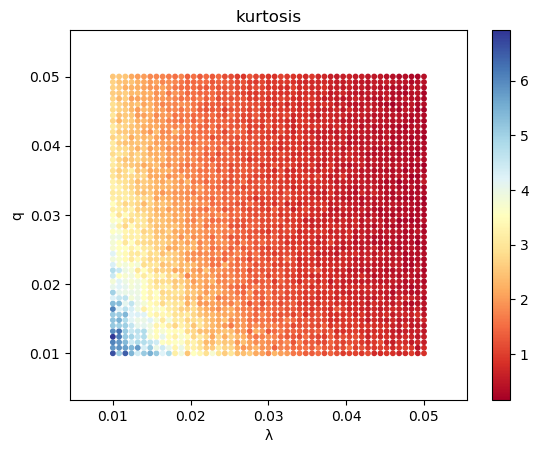

PyObject Text(0.5, 1, 'kurtosis')

In [7]:
scatter(df.λ, df.q, 10, df.k, cmap=get_cmap("RdYlBu"))
colorbar()
xlabel("λ")
ylabel("q")
title("kurtosis")

Fit a metamodel to the data

In [8]:
function best_model(df)
           function obj(x)
              f1(v) = v^x[1]
              f2(v) = v^x[2]
              return -r2(lm(@formula(k ~ f1(λ) * f2(q)), df))
          end
          return optimize(obj, rand(2) .- 0.5).minimizer
       end

best_model(df)

2-element Array{Float64,1}:
 -0.4469479729048501
 -0.6990739629600358

Calculate the estimates for the best model again

In [9]:
model = lm(@formula(k ~ (λ ^ -0.447) * (q ^ -0.699)), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

k ~ 1 + :(λ ^ -0.447) + :(q ^ -0.699) + :(λ ^ -0.447) & :(q ^ -0.699)

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                             Coef.   Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)              -0.338207  0.0468897     -7.21    <1e-12  -0.430152   -0.246262
λ ^ -0.447                0.150785  0.00899892    16.76    <1e-59   0.133139    0.16843
q ^ -0.699               -0.207633  0.00341081   -60.88    <1e-99  -0.214322   -0.200945
λ ^ -0.447 & q ^ -0.699   0.056664  0.000654592   86.56    <1e-99   0.0553804   0.0579475
─────────────────────────────────────────────────────────────────────────────────────────

and get its fit

In [10]:
r2(model)

0.9778978911436634

Find the range of marginal effects of $\lambda$ and $q$

In [11]:
function get_gradients(model, df)
          prediction(x) = predict(model, DataFrame(λ=x[1], q=x[2]))[1]
          grad_df = DataFrame(λ=Float64[], q=Float64[])
          foreach(eachrow(df)) do row
              push!(grad_df, ForwardDiff.gradient(prediction, [row.λ, row.q]))
          end
          return describe(grad_df, :min, :mean, :median, :max)
       end

get_gradients(model, df)

,variable,min,mean,median,max
,Symbol,Float64,Float64,Float64,Float64
1,λ,-548.955,-90.9051,-62.6697,-20.8335
2,q,-412.972,-35.1353,-18.6593,-0.97282
